# Notes

We provide this notebook for inference and visualizations. 

You can either load images from a dataloader(see Sec. 1) or from a local path(see Sec. 2).

Welcome to join [IDEA](https://idea.edu.cn/en)([中文网址](https://idea.edu.cn/))!

In [1]:
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

from torchvision.transforms import ToPILImage, ToTensor

# 0. Initialize and Load Pre-trained Models

In [2]:
#model_config_path = "config/DINO/custom_DINO_4scale_focalnet_large_fl3.py" # change the path of the model config file
model_config_path = "config/DINO/custom_DINO_4scale_swin.py"
model_checkpoint_path = "runs/flir/00002/checkpoint_best_regular.pth" # change the path of the model checkpoint
# See our Model Zoo section in README.md for more details about our pretrained models.
args = SLConfig.fromfile(model_config_path) 

In [3]:
args.device = 'cuda' 
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!


/home/jwchoi/anaconda3/envs/jwc/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
# load coco names
with open('util/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

# 1. Visualize images from a dataloader
## 1.1 Load Datasets

In [4]:
args.dataset_file = 'custom'
args.coco_path = "/home/jwchoi/Downloads/FLIRaligned/align" # the path of coco
args.fix_size = False

dataset_val = build_dataset(image_set='val', args=args)   
#dataset_test = build_dataset(image_set='test', args=args)  

data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
lookup = [
    {'id': 0, 'name': 'person', 'supercategory': 'none'},
    {'id': 1, 'name': 'bicycle', 'supercategory': 'none'},
    {'id': 2, 'name': 'car', 'supercategory': 'none'},
    {'id': 3, 'name': 'motorcycle', 'supercategory': 'none'},
    {'id': 4, 'name': 'bus', 'supercategory': 'none'},
    {'id': 5, 'name': 'train', 'supercategory': 'none'},
    {'id': 6, 'name': 'truck', 'supercategory': 'none'},
    {'id': 7, 'name': 'traffic light', 'supercategory': 'none'},
    {'id': 8, 'name': 'fire hydrant', 'supercategory': 'none'},
    {'id': 9, 'name': 'street sign', 'supercategory': 'none'},
    {'id': 10, 'name': 'dog', 'supercategory': 'none'},
    {'id': 11, 'name': 'skateboard', 'supercategory': 'none'},
    {'id': 12, 'name': 'stroller', 'supercategory': 'none'},
    {'id': 13, 'name': 'scooter', 'supercategory': 'none'},
    {'id': 14, 'name': 'other vehicle', 'supercategory': 'none'},
]
    
id2name = [x['name'] for x in lookup]

## 1.2 Get an Example and Visualize it

In [9]:
image, targets = dataset_val[100]
#image, targets = dataset_test[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


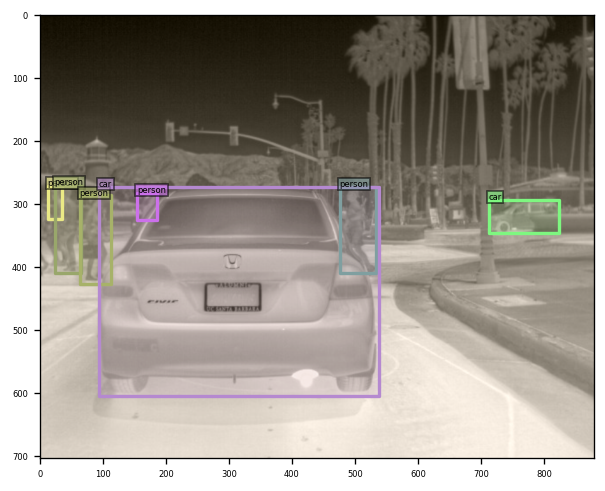

In [10]:
if image.shape[0] == 1:
    visimage = torch.cat([image,]*3, 0)
else:
    visimage = image

# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
#box_label = [int(item) for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(visimage, gt_dict, savedir=None)

In [88]:
gt_dict

{'boxes': tensor([[0.7554, 0.5445, 0.0493, 0.1659]]),
 'image_id': tensor([0]),
 'size': tensor([800, 800]),
 'box_label': [2]}

## 1.3 Visualize Model Predictions

In [11]:
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

/mnt/hdd/jwc/FocalNet-DINO/models/dino/position_encoding.py:95: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_tx = self.temperatureW ** (2 * (dim_tx // 2) / self.num_pos_feats)
/mnt/hdd/jwc/FocalNet-DINO/models/dino/position_encoding.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_ty = self.temperatureH ** (2 * (dim_ty //

In [23]:
output['boxes'][:3]

tensor([[0.0996, 0.3899, 0.6029, 0.8562],
        [0.8098, 0.4182, 0.9332, 0.4938],
        [0.5393, 0.3847, 0.6046, 0.5898]], device='cuda:0')

In [21]:
output['scores']

tensor([0.9755, 0.8316, 0.6438, 0.5669, 0.4925, 0.3509, 0.2918, 0.2713, 0.2619,
        0.2300, 0.2292, 0.2283, 0.2256, 0.2203, 0.2193, 0.2121, 0.1968, 0.1840,
        0.1773, 0.1711, 0.1671, 0.1617, 0.1573, 0.1554, 0.1550, 0.1533, 0.1531,
        0.1460, 0.1457, 0.1453, 0.1378, 0.1351, 0.1349, 0.1339, 0.1326, 0.1316,
        0.1281, 0.1217, 0.1190, 0.1092, 0.1088, 0.1087, 0.1055, 0.1053, 0.1037,
        0.1029, 0.1011, 0.1001, 0.0989, 0.0987, 0.0983, 0.0958, 0.0951, 0.0951,
        0.0944, 0.0939, 0.0922, 0.0911, 0.0893, 0.0885, 0.0882, 0.0868, 0.0854,
        0.0850, 0.0840, 0.0830, 0.0826, 0.0816, 0.0813, 0.0798, 0.0796, 0.0782,
        0.0759, 0.0753, 0.0750, 0.0746, 0.0735, 0.0735, 0.0733, 0.0715, 0.0701,
        0.0698, 0.0691, 0.0687, 0.0673, 0.0672, 0.0669, 0.0667, 0.0667, 0.0666,
        0.0654, 0.0645, 0.0636, 0.0634, 0.0628, 0.0623, 0.0621, 0.0615, 0.0604,
        0.0603, 0.0598, 0.0592, 0.0575, 0.0562, 0.0558, 0.0558, 0.0547, 0.0537,
        0.0535, 0.0533, 0.0528, 0.0518, 

In [24]:
thershold = 0.9 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


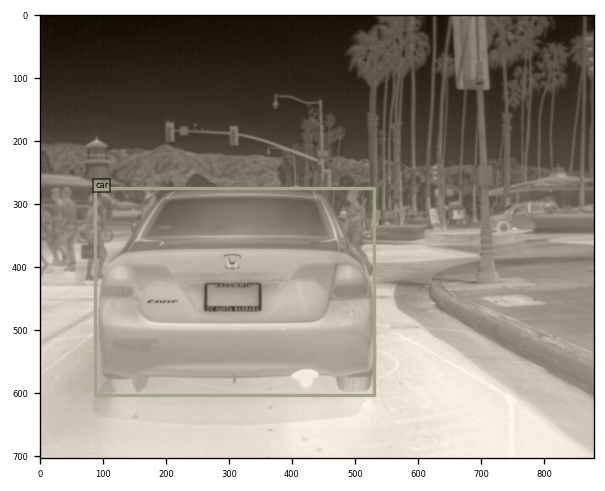

In [25]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
#box_label = [int(item) for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(visimage, pred_dict, savedir=None)

# 2. Visualize Custom Images

In [5]:
from PIL import Image
import datasets.transforms as T

In [6]:
image = Image.open("./figs/idea.jpg").convert("RGB") # load image

In [7]:
# transform images
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

In [ ]:
# predict images
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

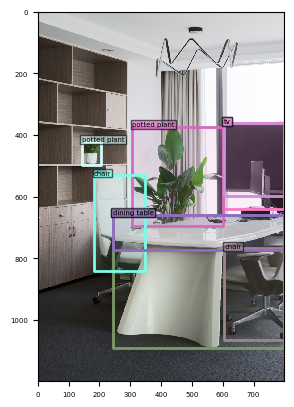

In [9]:
# visualize outputs
thershold = 0.3 # set a thershold

vslzr = COCOVisualizer()

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None, dpi=100)

In [2]:
import torch

In [6]:
ckpt = torch.load('runs/prelim/00002/checkpoint.pth', map_location='cpu')

In [7]:
ckpt.keys()

dict_keys(['model', 'optimizer', 'lr_scheduler', 'epoch', 'args'])

In [8]:
ckpt['epoch']

11

In [10]:
ckpt2 = torch.load('runs/prelim/00002/eval/latest.pth', map_location='cpu')

In [11]:
ckpt2.keys()

dict_keys(['params', 'counts', 'date', 'precision', 'recall', 'scores'])

In [13]:
ckpt2['scores'].shape

(10, 101, 3, 4, 3)

In [14]:
ckpt2['counts']

[10, 101, 3, 4, 3]

In [17]:
ckpt2['params'].__dict__

{'imgIds': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40],
 'catIds': [0, 1, 2],
 'iouThrs': array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 'recThrs': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.9

# FLIR to COCO

In [1]:
import json, yaml, os
import numpy as np
import glob
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import shutil
from tqdm.autonotebook import tqdm

from torchvision.transforms import ToTensor

from pycocotools.coco import COCO

/tmp/ipykernel_1857859/3069492139.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [145]:
datadirbase = '/home/jwchoi/Downloads/FLIRaligned/align'

In [153]:
keys_train = []
with open(os.path.join(datadirbase, 'align_train.txt'), 'r') as f:
    for line in f.readlines():
        keys_train.append(line.strip())
        
keys_valid = []
with open(os.path.join(datadirbase, 'align_validation.txt'), 'r') as f:
    for line in f.readlines():
        keys_valid.append(line.strip())

In [154]:
dir_train = os.path.join(datadirbase, 'train')
dir_valid = os.path.join(datadirbase, 'valid')
os.makedirs(dir_train, exist_ok=True)
os.makedirs(dir_valid, exist_ok=True)

In [155]:
imagedirbase = '/home/jwchoi/Downloads/FLIRaligned/align/JPEGImages'
annotdirbase = '/home/jwchoi/Downloads/FLIRaligned/align/Annotations'

In [158]:
for k in tqdm(keys_train):
    src = os.path.join(imagedirbase, f'{k}.jpeg')
    dst = os.path.join(dir_train, f'{k}.jpeg')
    shutil.copy(src, dst)

  0%|          | 0/4129 [00:00<?, ?it/s]

In [159]:
for k in tqdm(keys_valid):
    src = os.path.join(imagedirbase, f'{k}.jpeg')
    dst = os.path.join(dir_valid, f'{k}.jpeg')
    shutil.copy(src, dst)

  0%|          | 0/1013 [00:00<?, ?it/s]

In [163]:
def find_image_id(key, images, extension='.jpeg'):
    for x in images:
        if x['file_name'].split(extension)[0] == key:
            return x['id']
    return None

def find_cat_id(name, categories):
    for x in categories:
        if x['name'] == name:
            return x['id']
    return None

def find_cat_name(idx, categories):
    for x in categories:
        if x['id'] == idx:
            return x['name']
    return None

In [178]:
#dir_X = dir_train
dir_X = dir_valid

In [179]:
imgfiles = sorted(glob.glob(os.path.join(dir_X, '*.jpeg')))
keys = [os.path.basename(x).split('.jpeg')[0] for x in imgfiles]
print(len(keys), len(keys_valid))

1013 1013


In [180]:
dsannot = {
    'info': {},
    'license':[{'id': 1, 'url': '', 'name': 'Unknown'}],
    'categories': [
        {'id': 0, 'name': 'person', 'supercategory': 'none'},
        {'id': 1, 'name': 'bicycle', 'supercategory': 'none'},
        {'id': 2, 'name': 'car', 'supercategory': 'none'},
        {'id': 3, 'name': 'motorcycle', 'supercategory': 'none'},
        {'id': 4, 'name': 'bus', 'supercategory': 'none'},
        {'id': 5, 'name': 'train', 'supercategory': 'none'},
        {'id': 6, 'name': 'truck', 'supercategory': 'none'},
        {'id': 7, 'name': 'traffic light', 'supercategory': 'none'},
        {'id': 8, 'name': 'fire hydrant', 'supercategory': 'none'},
        {'id': 9, 'name': 'street sign', 'supercategory': 'none'},
        {'id': 10, 'name': 'dog', 'supercategory': 'none'},
        {'id': 11, 'name': 'skateboard', 'supercategory': 'none'},
        {'id': 12, 'name': 'stroller', 'supercategory': 'none'},
        {'id': 13, 'name': 'scooter', 'supercategory': 'none'},
        {'id': 14, 'name': 'other vehicle', 'supercategory': 'none'},
    ],
}

In [181]:
dsannot_images = []
cnt = 0
for x in tqdm(imgfiles):
    im = Image.open(x)
    w, h = im.size
    dsannot_images.append({
        'id': cnt,
        'license': 1,
        'file_name': os.path.basename(x),
        'height': h,
        'width': w,
    })
    cnt += 1
dsannot['images'] = dsannot_images

annots = []
cnt = 0
for k in tqdm(keys):
    annotfile = os.path.join(annotbase, f'{k}.xml')
    tree = ET.parse(annotfile)
    root = tree.getroot()
    
    image_id = find_image_id(k, dsannot['images'])
    if image_id is None:
        print(f'cannot find image_id for {k}')
        continue
    
    for x in root.iter('object'):
        
        cat_name = None
        xmin = None
        ymin = None
        xmax = None
        ymax = None
        for c in x:
            if c.tag == 'name':
                cat_name = c.text
            if c.tag == 'bndbox':
                for m in c:
                    if m.tag == 'xmin':
                        xmin = float(m.text)
                    elif m.tag == 'xmax':
                        xmax = float(m.text)
                    elif m.tag == 'ymin':
                        ymin = float(m.text)
                    elif m.tag == 'ymax':
                        ymax = float(m.text)
        
        cat_id = find_cat_id(cat_name, dsannot['categories'])
        if cat_id is None:
            print(f'cannot find cat_id for {cat_name}')
            continue
            
        cannot = {
            'id': cnt,
            'image_id': image_id,
            'category_id': cat_id,
            'bbox': [xmin, ymin, xmax-xmin, ymax-ymin],
            'area': (xmax-xmin)*(ymax-ymin),
            'segmentation': [],
            'iscrowd': 0
        }
        annots.append(cannot)
        
        cnt += 1 
dsannot['annotations'] = annots

with open(os.path.join(dir_X, '_annotations.coco.json'), 'w') as f:
    json.dump(dsannot, f)

  0%|          | 0/1013 [00:00<?, ?it/s]

  0%|          | 0/1013 [00:00<?, ?it/s]

In [184]:
os.path.join(dir_train, '_annotations.coco.json')

'/home/jwchoi/Downloads/FLIRaligned/align/train/_annotations.coco.json'

In [2]:
checkcoco = COCO('/home/jwchoi/Downloads/FLIRaligned/align/valid/_annotations.coco.json')

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [3]:
checkcoco

In [6]:
res = COCO()

In [7]:
res.dataset

{}

In [ ]:
res.dataset['images'] = [img for img in self.dataset['images']]
AttributeError: 'NoneType' object has no attribute 'dataset'

In [188]:
imgIds = checkcoco.getImgIds()

In [194]:
widths = []
heights = []
for x in checkcoco.loadImgs(imgIds):
    widths.append(x['width'])
    heights.append(x['height'])

In [196]:
np.min(heights), np.max(heights)

(512, 512)

In [114]:
import json, yaml, os
import numpy as np
import glob
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
from tqdm.autonotebook import tqdm

from torchvision.transforms import ToTensor

In [2]:
datadirbase = '/home/jwchoi/Downloads/FLIRaligned/align/JPEGImages'

In [3]:
annotbase = '/home/jwchoi/Downloads/FLIRaligned/align/Annotations'

In [46]:
dsannot = {
    'info': {},
    'license':[{'id': 1, 'url': '', 'name': 'Unknown'}],
    'categories': [
        {'id': 0, 'name': 'person', 'supercategory': 'none'},
        {'id': 1, 'name': 'bicycle', 'supercategory': 'none'},
        {'id': 2, 'name': 'car', 'supercategory': 'none'},
        {'id': 3, 'name': 'motorcycle', 'supercategory': 'none'},
        {'id': 4, 'name': 'bus', 'supercategory': 'none'},
        {'id': 5, 'name': 'train', 'supercategory': 'none'},
        {'id': 6, 'name': 'truck', 'supercategory': 'none'},
        {'id': 7, 'name': 'traffic light', 'supercategory': 'none'},
        {'id': 8, 'name': 'fire hydrant', 'supercategory': 'none'},
        {'id': 9, 'name': 'street sign', 'supercategory': 'none'},
        {'id': 10, 'name': 'dog', 'supercategory': 'none'},
        {'id': 11, 'name': 'skateboard', 'supercategory': 'none'},
        {'id': 12, 'name': 'stroller', 'supercategory': 'none'},
        {'id': 13, 'name': 'scooter', 'supercategory': 'none'},
        {'id': 14, 'name': 'other vehicle', 'supercategory': 'none'},
    ],
}

In [47]:
imgfiles = sorted(glob.glob(os.path.join(datadirbase, '*PreviewData.jpeg')))
keys = [os.path.basename(x).split('.jpeg')[0] for x in imgfiles]

In [48]:
dsannot_images = []
cnt = 0
for x in tqdm(imgfiles):
    im = Image.open(x)
    w, h = im.size
    dsannot_images.append({
        'id': cnt,
        'license': 1,
        'file_name': os.path.basename(x),
        'height': h,
        'width': w,
    })
    cnt += 1
dsannot['images'] = dsannot_images

  0%|          | 0/5142 [00:00<?, ?it/s]

In [140]:
def find_image_id(key, images, extension='.jpeg'):
    for x in images:
        if x['file_name'].split(extension)[0] == key:
            return x['id']
    return None

def find_cat_id(name, categories):
    for x in categories:
        if x['name'] == name:
            return x['id']
    return None

def find_cat_name(idx, categories):
    for x in categories:
        if x['id'] == idx:
            return x['name']
    return None

In [50]:
annots = []
cnt = 0
for k in tqdm(keys):
    annotfile = os.path.join(annotbase, f'{k}.xml')
    tree = ET.parse(annotfile)
    root = tree.getroot()
    
    image_id = find_image_id(k, dsannot['images'])
    if image_id is None:
        print(f'cannot find image_id for {k}')
        continue
    
    for x in root.iter('object'):
        
        cat_name = None
        xmin = None
        ymin = None
        xmax = None
        ymax = None
        for c in x:
            if c.tag == 'name':
                cat_name = c.text
            if c.tag == 'bndbox':
                for m in c:
                    if m.tag == 'xmin':
                        xmin = float(m.text)
                    elif m.tag == 'xmax':
                        xmax = float(m.text)
                    elif m.tag == 'ymin':
                        ymin = float(m.text)
                    elif m.tag == 'ymax':
                        ymax = float(m.text)
        
        cat_id = find_cat_id(cat_name, dsannot['categories'])
        if cat_id is None:
            print(f'cannot find cat_id for {cat_name}')
            continue
            
        cannot = {
            'id': cnt,
            'image_id': image_id,
            'category_id': cat_id,
            'bbox': [xmin, ymin, xmax-xmin, ymax-ymin],
            'area': (xmax-xmin)*(ymax-ymin),
            'segmentation': [],
            'iscrowd': 0
        }
        annots.append(cannot)
        
        cnt += 1 
dsannot['annotations'] = annots

  0%|          | 0/5142 [00:00<?, ?it/s]

In [52]:
with open('flir_ds.json', 'w') as f:
    json.dump(dsannot, f)

In [53]:
from pycocotools.coco import COCO

In [55]:
coco = COCO('flir_ds.json')

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


In [68]:
catIds = coco.getCatIds(catNms=['dog', 'person'])
imgIds = coco.getImgIds(catIds=catIds)

In [89]:
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)

In [124]:
imgpath = os.path.join(datadirbase, img['file_name'])
imgpil = Image.open(imgpath)

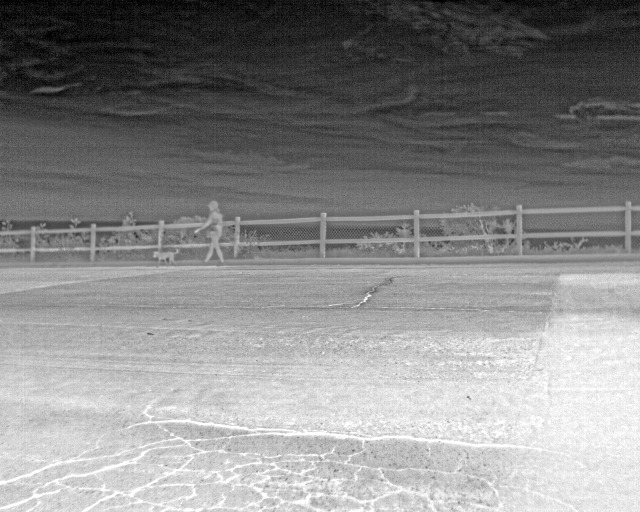

In [137]:
imgpil

In [122]:
draw = ImageDraw.Draw(imgpil)
draw.rectangle(
    (anns[0]['bbox'][0], anns[0]['bbox'][1], anns[0]['bbox'][0]+anns[0]['bbox'][2], anns[0]['bbox'][1] + anns[0]['bbox'][3]))
draw.rectangle(
    (anns[1]['bbox'][0], anns[1]['bbox'][1], anns[1]['bbox'][0]+anns[1]['bbox'][2], anns[1]['bbox'][1] + anns[1]['bbox'][3]))


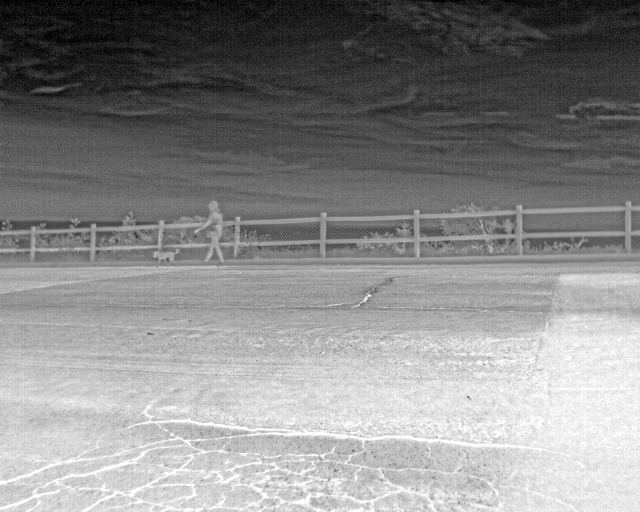

In [143]:
imgpil.convert('RGB')

In [141]:
timg = ToTensor()(imgpil.convert('RGB'))
img_size = torch.tensor([img['height'], img['width']])
img_id = torch.tensor([img['id']])

c_boxes = []
c_box_label = []
for box in anns:
    xmin, ymin, w, h = box['bbox']
    xmin = xmin / img_size[1]
    w = w / img_size[1]
    ymin = ymin / img_size[0]
    h = h / img_size[0]
    cx = xmin + 0.5*w
    cy = ymin + 0.5*h
    
    
    c_boxes.append([cx, cy, w, h])
    c_box_label.append(find_cat_name(box['category_id'], dsannot['categories']))

c_boxes = torch.tensor(c_boxes)
#c_box_label = torch.tensor(c_box_label)

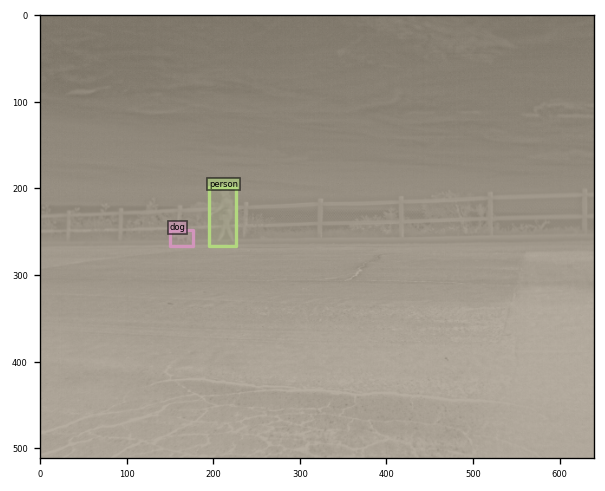

In [142]:
current_dict = {
    'boxes': c_boxes,
    'image_id': img_id,
    'size': img_size,
    'box_label': c_box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(timg, current_dict, savedir=None)

In [134]:
current_dict

{'boxes': tensor([[0.2344, 0.4844, 0.0422, 0.0352],
         [0.3047, 0.3867, 0.0484, 0.1328]]),
 'image_id': tensor([2142]),
 'size': tensor([512, 640]),
 'box_label': [10, 0]}

In [135]:
150/640

0.234375

In [100]:
img

{'id': 2142,
 'license': 1,
 'file_name': 'FLIR_03506_PreviewData.jpeg',
 'height': 512,
 'width': 640}

In [102]:
anns

[{'id': 17840,
  'image_id': 2142,
  'category_id': 10,
  'bbox': [150.0, 248.0, 27.0, 18.0],
  'area': 486.0,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 17841,
  'image_id': 2142,
  'category_id': 0,
  'bbox': [195.0, 198.0, 31.0, 68.0],
  'area': 2108.0,
  'segmentation': [],
  'iscrowd': 0}]

In [ ]:
box_label = [int(item) for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

In [99]:
timg.shape

torch.Size([1, 512, 640])

In [92]:
gt_dict

{'boxes': tensor([[0.7554, 0.5445, 0.0493, 0.1659]]),
 'image_id': tensor([0]),
 'size': tensor([800, 800]),
 'box_label': [2]}

In [24]:
{'id': 0,
  'image_id': 0,
  'category_id': 2,
  'bbox': [255, 206, 27, 41.5],
  'area': 1120.5,
  'segmentation': [],
  'iscrowd': 0},

[]

In [94]:
image.shape

torch.Size([3, 800, 800])

In [80]:
anns

[{'id': 18008,
  'image_id': 2168,
  'category_id': 0,
  'bbox': [349.0, 241.0, 43.0, 90.0],
  'area': 3870.0,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 18009,
  'image_id': 2168,
  'category_id': 10,
  'bbox': [301.0, 297.0, 55.0, 37.0],
  'area': 2035.0,
  'segmentation': [],
  'iscrowd': 0}]

In [81]:
dsannot['categories']

[{'id': 0, 'name': 'person', 'supercategory': 'none'},
 {'id': 1, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 2, 'name': 'car', 'supercategory': 'none'},
 {'id': 3, 'name': 'motorcycle', 'supercategory': 'none'},
 {'id': 4, 'name': 'bus', 'supercategory': 'none'},
 {'id': 5, 'name': 'train', 'supercategory': 'none'},
 {'id': 6, 'name': 'truck', 'supercategory': 'none'},
 {'id': 7, 'name': 'traffic light', 'supercategory': 'none'},
 {'id': 8, 'name': 'fire hydrant', 'supercategory': 'none'},
 {'id': 9, 'name': 'street sign', 'supercategory': 'none'},
 {'id': 10, 'name': 'dog', 'supercategory': 'none'},
 {'id': 11, 'name': 'skateboard', 'supercategory': 'none'},
 {'id': 12, 'name': 'stroller', 'supercategory': 'none'},
 {'id': 13, 'name': 'scooter', 'supercategory': 'none'},
 {'id': 14, 'name': 'other vehicle', 'supercategory': 'none'}]

In [47]:
for child in root:
     print(child.tag, child.attrib)

folder {}
source {}
owner {}
filename {}
size {}
object {}
object {}
object {}
object {}
object {}
object {}


In [23]:
dfc['info']

{'year': '2020',
 'version': '1',
 'description': 'Exported from roboflow.ai',
 'contributor': '',
 'url': 'https://public.roboflow.ai/object-detection/undefined',
 'date_created': '2020-05-25T00:08:21+00:00'}

In [ ]:
# "bbox" : [x,y,width,height], 
'''
0 Person
1 Bike
2 Car
3 Motorcycle
4 Bus
5 Train
6 Truck
7 Traffic light
8 Fire Hydrant
9 Street Sign
10 Dog
11 Skateboard
12 Stroller
13 Scooter
14 Other Vehicle
'''

# COCO json format

In [11]:
import json
with open('/home/jwchoi/Downloads/thermaldogpeople/train/_annotations.coco.json', 'rb') as f:
    dfc = json.load(f)

In [12]:
dfc.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [13]:
dfc['licenses']

[{'id': 1, 'url': '', 'name': 'Unknown'}]

In [19]:
dfc['categories']

[{'id': 0, 'name': 'dogs-person', 'supercategory': 'none'},
 {'id': 1, 'name': 'dog', 'supercategory': 'dogs-person'},
 {'id': 2, 'name': 'person', 'supercategory': 'dogs-person'}]

In [20]:
dfc['images']

[{'id': 0,
  'license': 1,
  'file_name': 'IMG_0094_jpg.rf.03dbd175cdbd5379608debcc783a5361.jpg',
  'height': 416,
  'width': 416,
  'date_captured': '2020-05-25T00:08:21+00:00'},
 {'id': 1,
  'license': 1,
  'file_name': 'IMG_0054_jpg.rf.03e0fd11bad6afeb085f2f156d7fd043.jpg',
  'height': 416,
  'width': 416,
  'date_captured': '2020-05-25T00:08:21+00:00'},
 {'id': 2,
  'license': 1,
  'file_name': 'IMG_0056_jpg.rf.0255dca8946ea0a34592394acd67b11b.jpg',
  'height': 416,
  'width': 416,
  'date_captured': '2020-05-25T00:08:21+00:00'},
 {'id': 3,
  'license': 1,
  'file_name': 'IMG_0109_jpg.rf.03607def018d49330ebef9a856f65812.jpg',
  'height': 416,
  'width': 416,
  'date_captured': '2020-05-25T00:08:21+00:00'},
 {'id': 4,
  'license': 1,
  'file_name': 'IMG_0112_jpg.rf.016d04c2af3bc0221a5153d6af8b9f30.jpg',
  'height': 416,
  'width': 416,
  'date_captured': '2020-05-25T00:08:21+00:00'},
 {'id': 5,
  'license': 1,
  'file_name': 'IMG_0064_jpg.rf.07406ea9809d2492712b3e2fa3a857b3.jpg',
  

In [ ]:
dfc['annotations']

# Scrap

In [4]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
datadir = '/home/jwchoi/Downloads/FLIRaligned/align/JPEGImages'

In [5]:
tpath = os.path.join(datadir, 'FLIR_02612_PreviewData.jpeg')
#tpath = os.path.join(datadir, 'FLIR_02612_RGB.jpg')

In [6]:
tim = Image.open(tpath)

In [9]:
np.array(tim).shape

(512, 640)

In [183]:
np.mean([0.485, 0.456, 0.406]), np.mean([0.229, 0.224, 0.225])

(0.449, 0.226)

In [1]:
import torch

In [2]:
ckpt = torch.load('temp/pretrained/dino/checkpoint0029_4scale_swin.pth', map_location='cpu')

In [4]:
ckpt = torch.load('temp/pretrained/swin_large_patch4_window12_384_22k.pth', map_location='cpu')

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [1]:
import torch
import numpy as np
from pycocotools.cocoeval import COCOeval

In [2]:
class coco_metrics(object):
    def __init__(self, filepath):
        mets = torch.load(filepath, map_location='cpu')
        self.eval = mets
        self.params = mets['params']
        
    def summarize(self):
        '''
        Compute and display summary metrics for evaluation results.
        Note this functin can *only* be applied on the default parameter setting
        '''
        def _summarize( ap=1, iouThr=None, areaRng='all', maxDets=100 ):
            p = self.params
            iStr = ' {:<18} {} @[ IoU={:<9} | area={:>6s} | maxDets={:>3d} ] = {:0.3f}'
            titleStr = 'Average Precision' if ap == 1 else 'Average Recall'
            typeStr = '(AP)' if ap==1 else '(AR)'
            iouStr = '{:0.2f}:{:0.2f}'.format(p.iouThrs[0], p.iouThrs[-1]) \
                if iouThr is None else '{:0.2f}'.format(iouThr)

            aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == areaRng]
            mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]
            if ap == 1:
                # dimension of precision: [TxRxKxAxM]
                s = self.eval['precision']
                # IoU
                if iouThr is not None:
                    t = np.where(iouThr == p.iouThrs)[0]
                    s = s[t]
                s = s[:,:,:,aind,mind]
            else:
                # dimension of recall: [TxKxAxM]
                s = self.eval['recall']
                if iouThr is not None:
                    t = np.where(iouThr == p.iouThrs)[0]
                    s = s[t]
                s = s[:,:,aind,mind]
            if len(s[s>-1])==0:
                mean_s = -1
            else:
                mean_s = np.mean(s[s>-1])
            print(iStr.format(titleStr, typeStr, iouStr, areaRng, maxDets, mean_s))
            return mean_s
        def _summarizeDets():
            stats = np.zeros((12,))
            stats[0] = _summarize(1)
            stats[1] = _summarize(1, iouThr=.5, maxDets=self.params.maxDets[2])
            stats[2] = _summarize(1, iouThr=.75, maxDets=self.params.maxDets[2])
            stats[3] = _summarize(1, areaRng='small', maxDets=self.params.maxDets[2])
            stats[4] = _summarize(1, areaRng='medium', maxDets=self.params.maxDets[2])
            stats[5] = _summarize(1, areaRng='large', maxDets=self.params.maxDets[2])
            stats[6] = _summarize(0, maxDets=self.params.maxDets[0])
            stats[7] = _summarize(0, maxDets=self.params.maxDets[1])
            stats[8] = _summarize(0, maxDets=self.params.maxDets[2])
            stats[9] = _summarize(0, areaRng='small', maxDets=self.params.maxDets[2])
            stats[10] = _summarize(0, areaRng='medium', maxDets=self.params.maxDets[2])
            stats[11] = _summarize(0, areaRng='large', maxDets=self.params.maxDets[2])
            return stats
        def _summarizeKps():
            stats = np.zeros((10,))
            stats[0] = _summarize(1, maxDets=20)
            stats[1] = _summarize(1, maxDets=20, iouThr=.5)
            stats[2] = _summarize(1, maxDets=20, iouThr=.75)
            stats[3] = _summarize(1, maxDets=20, areaRng='medium')
            stats[4] = _summarize(1, maxDets=20, areaRng='large')
            stats[5] = _summarize(0, maxDets=20)
            stats[6] = _summarize(0, maxDets=20, iouThr=.5)
            stats[7] = _summarize(0, maxDets=20, iouThr=.75)
            stats[8] = _summarize(0, maxDets=20, areaRng='medium')
            stats[9] = _summarize(0, maxDets=20, areaRng='large')
            return stats
        if not self.eval:
            raise Exception('Please run accumulate() first')
        iouType = self.params.iouType
        if iouType == 'segm' or iouType == 'bbox':
            summarize = _summarizeDets
        elif iouType == 'keypoints':
            summarize = _summarizeKps
        self.stats = summarize()

In [9]:
mets = coco_metrics('runs/flir/00001/eval/latest.pth')
mets.summarize()

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.357
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.431
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.712


In [10]:
mets = coco_metrics('runs/flir/00002/eval/latest.pth')
mets.summarize()

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.358
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.649
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.224
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.507
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.756


In [2]:
mets = torch.load('runs/prelim/00006/eval/latest.pth', map_location='cpu')

In [3]:
mets.keys()

dict_keys(['params', 'counts', 'date', 'precision', 'recall', 'scores'])

In [5]:
mets['scores'].shape

(10, 101, 15, 4, 3)

In [8]:
mets['precision'].shape

(10, 101, 15, 4, 3)

In [10]:
mets['params']

In [ ]:
    def summarize(self):
        '''
        Compute and display summary metrics for evaluation results.
        Note this functin can *only* be applied on the default parameter setting
        '''
        def _summarize( ap=1, iouThr=None, areaRng='all', maxDets=100 ):
            p = self.params
            iStr = ' {:<18} {} @[ IoU={:<9} | area={:>6s} | maxDets={:>3d} ] = {:0.3f}'
            titleStr = 'Average Precision' if ap == 1 else 'Average Recall'
            typeStr = '(AP)' if ap==1 else '(AR)'
            iouStr = '{:0.2f}:{:0.2f}'.format(p.iouThrs[0], p.iouThrs[-1]) \
                if iouThr is None else '{:0.2f}'.format(iouThr)

            aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == areaRng]
            mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]
            if ap == 1:
                # dimension of precision: [TxRxKxAxM]
                s = self.eval['precision']
                # IoU
                if iouThr is not None:
                    t = np.where(iouThr == p.iouThrs)[0]
                    s = s[t]
                s = s[:,:,:,aind,mind]
            else:
                # dimension of recall: [TxKxAxM]
                s = self.eval['recall']
                if iouThr is not None:
                    t = np.where(iouThr == p.iouThrs)[0]
                    s = s[t]
                s = s[:,:,aind,mind]
            if len(s[s>-1])==0:
                mean_s = -1
            else:
                mean_s = np.mean(s[s>-1])
            print(iStr.format(titleStr, typeStr, iouStr, areaRng, maxDets, mean_s))
            return mean_s
        def _summarizeDets():
            stats = np.zeros((12,))
            stats[0] = _summarize(1)
            stats[1] = _summarize(1, iouThr=.5, maxDets=self.params.maxDets[2])
            stats[2] = _summarize(1, iouThr=.75, maxDets=self.params.maxDets[2])
            stats[3] = _summarize(1, areaRng='small', maxDets=self.params.maxDets[2])
            stats[4] = _summarize(1, areaRng='medium', maxDets=self.params.maxDets[2])
            stats[5] = _summarize(1, areaRng='large', maxDets=self.params.maxDets[2])
            stats[6] = _summarize(0, maxDets=self.params.maxDets[0])
            stats[7] = _summarize(0, maxDets=self.params.maxDets[1])
            stats[8] = _summarize(0, maxDets=self.params.maxDets[2])
            stats[9] = _summarize(0, areaRng='small', maxDets=self.params.maxDets[2])
            stats[10] = _summarize(0, areaRng='medium', maxDets=self.params.maxDets[2])
            stats[11] = _summarize(0, areaRng='large', maxDets=self.params.maxDets[2])
            return stats